# PCA on Beta Pictoris
- `eleanor` does not have an automatic `pca_flux` for custom aperture lightcurves, so here I create one. 
- The PCA is done by gathering neighbouring lightcurves in the TPF, and then performed the same way as `eleanor` does from [this page](https://github.com/afeinstein20/eleanor/blob/main/notebooks/pca.ipynb).

In [1]:
import eleanor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
star = eleanor.Source(tic=270577175, sector=6)
data = eleanor.TargetData(star,height=15,width=15)

INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]


In [3]:
q = data.quality == 0

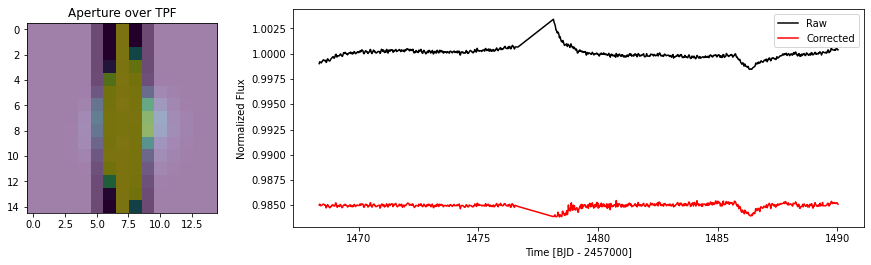

In [4]:
eleanor.TargetData.custom_aperture(data, shape='rectangle',h=15,w=4,pos=[7,7])
eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.015, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

In [5]:
bpic_raw_flux = data.raw_flux
bpic_flux = data.corr_flux

In [6]:
# TICs gathered from Sam Gill's `bruce` package
nearby = [270577175, 27057440, 270577169, 270577170, 270577168]

In [7]:
fluxes = [] 
for i in nearby:
    print(i)
    try:
        star = eleanor.Source(tic=i, sector=6)
        data = eleanor.TargetData(star,height=15,width=15)
        eleanor.TargetData.custom_aperture(data, shape='rectangle',h=15,w=4,pos=[7,7])
        eleanor.TargetData.get_lightcurve(data)
        q = data.quality == 0
        flux = data.corr_flux[q]
        fluxes.append(np.array(flux)/np.nanmedian(flux))
    except:
        print(f"TIC {i} not downloaded, moving on.")
        continue
fluxes = np.array(fluxes)

270577175
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]
27057440
TIC 27057440 not downloaded, moving on.
270577169
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-

In [8]:
fluxes.shape

(4, 937)

In [9]:
fluxes

array([[1.00002699, 1.00011381, 0.99995802, ..., 1.00026063, 1.00016783,
        1.00010059],
       [1.00025724, 1.00026836, 1.00027705, ..., 1.00006647, 1.00002113,
        1.00001776],
       [1.0016908 , 1.00104167, 1.00092128, ..., 0.99914365, 0.99929794,
        0.99914588],
       [1.00039909, 1.00004997, 0.99978672, ..., 0.99999232, 1.00012411,
        1.00007918]])

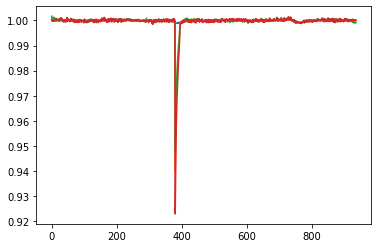

In [10]:
plt.plot(fluxes.T)

In [11]:
from sklearn.decomposition import PCA


In [12]:
pca = PCA(n_components=3)
commons = pca.fit(fluxes.T)
transform = pca.transform(fluxes.T)

transform.shape

(937, 3)

(-0.003, 0.0023)

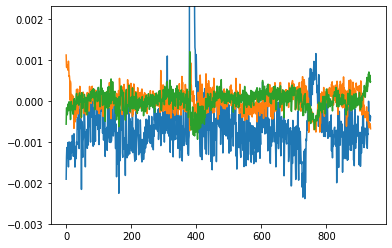

In [13]:
plt.plot(transform[:,])
plt.ylim([-0.003,0.0023])

In [14]:
pca.explained_variance_ratio_

array([0.99624596, 0.00158305, 0.00119274])

In [15]:
reconstructed_data = np.dot(transform, pca.components_) + pca.mean_


In [16]:
reconstructed_data

array([[0.99996389, 1.00032181, 1.00168754, 1.00035217],
       [1.00013434, 1.00024734, 1.00104273, 1.00006524],
       [1.00011941, 1.00011187, 1.00092961, 0.99990673],
       ...,
       [1.00019951, 1.00012902, 0.9991405 , 0.99994688],
       [1.00008383, 1.0001071 , 0.9992936 , 1.00006164],
       [1.00005695, 1.00006242, 0.99914363, 1.00004673]])

(0.98, 1.01)

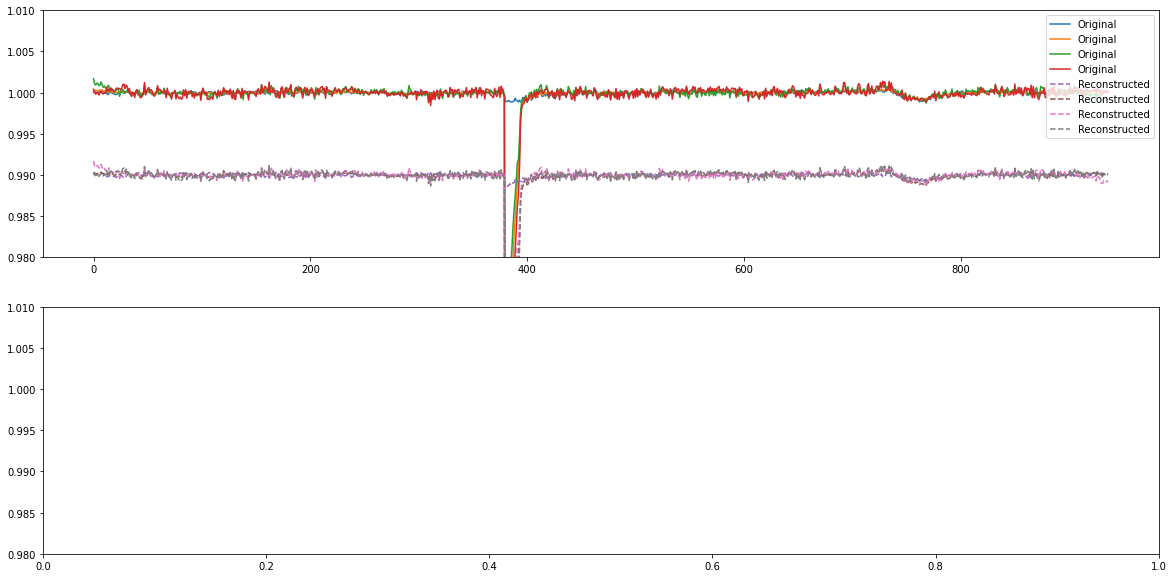

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(20, 10))
ax1.plot(fluxes.T, label='Original')
ax1.plot(reconstructed_data-0.01, label='Reconstructed', linestyle='--')
ax1.legend()
plt.ylim(0.98,1.01)

In [18]:
reconstructed_data.shape

(937, 4)

In [19]:
A = transform#[:,0:3]
f = fluxes[1]
ATA = np.dot(A.T, A)
invATA  = np.linalg.inv(ATA)
A_coeff = np.dot(invATA, A.T)
weights = np.dot(A_coeff, f) ## same as xhat

(0.997, 1.003)

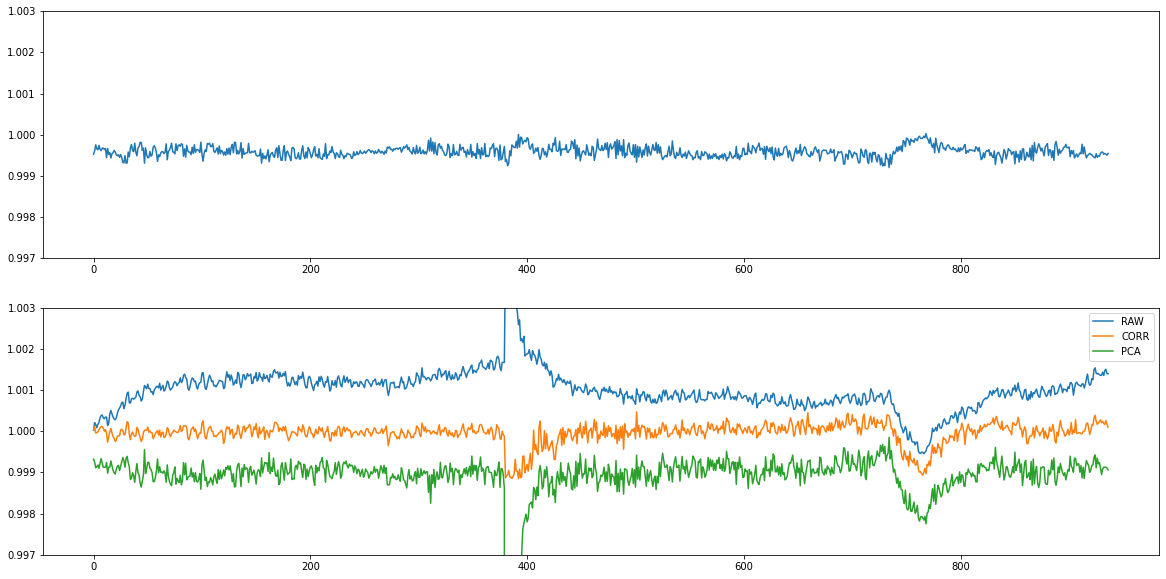

In [20]:
science = f - np.dot(A, weights)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=True,figsize=(20,10))
ax1.plot(science)
ax2.plot(bpic_raw_flux[q]/np.nanmedian(bpic_raw_flux[q])+0.001, label= 'RAW')
ax2.plot(bpic_flux[q]/np.nanmedian(bpic_flux[q]),label = 'CORR')
ax2.plot(reconstructed_data[:,1]-0.001,label='PCA')
ax2.legend()
ax2.set_ylim([0.997,1.003])

**PCA Flux should have kept the Beta Pic transit**

In [21]:
flux = reconstructed_data[:,1]

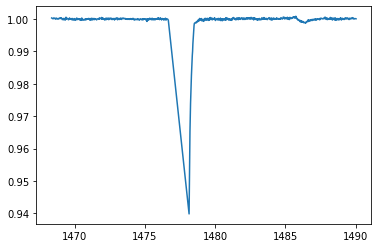

In [22]:
plt.plot(data.time[q],flux)

### Import MAD data 

In [23]:
import os
os.chdir('../../scripts')
import xrpdata

In [24]:
mad = pd.read_json("xrpdata/Sectors_MAD.json")

In [26]:
#mad_arr = mad.loc[: len(flux) - 1, f"{lc_info[3]}-{lc_info[4]}"]

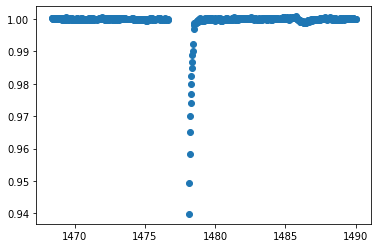

In [27]:
plt.scatter(data.time[q],flux)

In [28]:
np.where(flux == flux.min())

(array([380]),)

In [29]:
flux[380:397] = np.nanmedian(flux)

In [30]:
flux_err = data.flux_err[q] / data.corr_flux[q]

In [31]:
flux_err.shape

(937,)

In [32]:
df = pd.DataFrame(data=[data.time[q],flux,np.zeros(len(flux)),flux_err]).T

In [33]:
cols = ['TIME','FLUX','QUALITY','FLUX_ERR']
df.columns = cols

In [34]:
df

,TIME,FLUX,QUALITY,FLUX_ERR
0,1468.345850,1.000322,0.0,0.000017
1,1468.366684,1.000247,0.0,0.000017
2,1468.408350,1.000112,0.0,0.000017
3,1468.429184,1.000142,0.0,0.000017
4,1468.450017,1.000181,0.0,0.000017
...,...,...,...,...
932,1489.929057,1.000127,0.0,0.000017
933,1489.949890,1.000126,0.0,0.000017
934,1489.991556,1.000129,0.0,0.000017
935,1490.012389,1.000107,0.0,0.000017


In [38]:
from analysis_tools_cython import processing, import_lightcurve
from astropy.table import Table

In [39]:
table = Table.from_pandas(df)

In [36]:
_, lc_info = import_lightcurve('../hlsp_gsfc-eleanor-lite_tess_ffi_s0006-0000000270577175_tess_v1.0_lc.fits')

KeyError: 'FLUX_BKG'

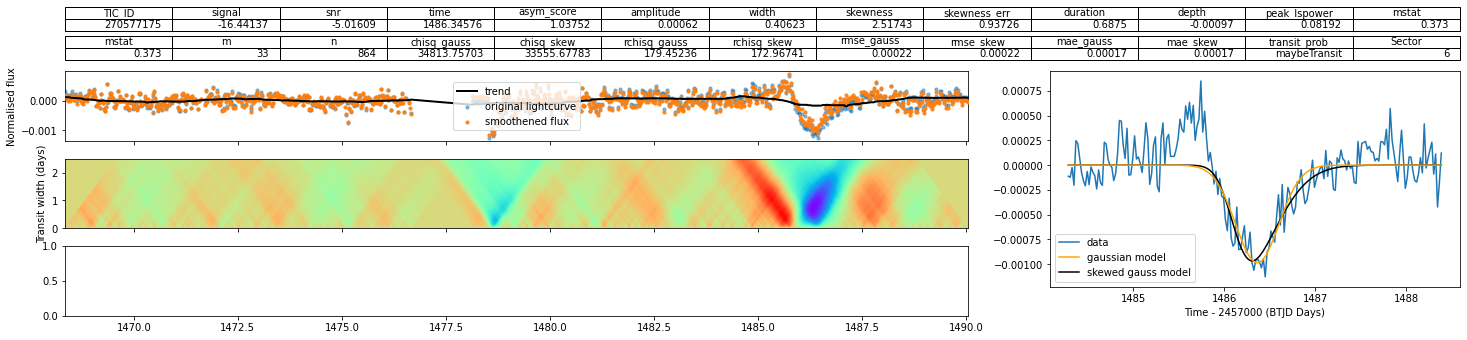

In [49]:
results, _ = processing(table,lc_info=lc_info,method='median',make_plots=True)

In [50]:
import pickle

In [51]:
results = results.split()

AttributeError: 'list' object has no attribute 'split'

In [52]:
with open('betapic_results.pkl', 'wb') as file:
    pickle.dump(results, file)